In [1]:
## Boilerplate imports

import pandas as pd
from pathlib import Path
import json
import pyrosetta
import pyrosetta_help as ph
from types import ModuleType
# Better than star imports:
prc: ModuleType = pyrosetta.rosetta.core
prp: ModuleType = pyrosetta.rosetta.protocols
pru: ModuleType = pyrosetta.rosetta.utility
prn: ModuleType = pyrosetta.rosetta.numeric
prs: ModuleType = pyrosetta.rosetta.std
pr_conf: ModuleType = pyrosetta.rosetta.core.conformation
pr_scoring: ModuleType = pyrosetta.rosetta.core.scoring
pr_res: ModuleType = pyrosetta.rosetta.core.select.residue_selector
pr_options: ModuleType = pyrosetta.rosetta.basic.options

logger = ph.configure_logger()
pyrosetta.distributed.maybe_init(extra_options=ph.make_option_string(no_optH=False,
                                                                     ex1=None,
                                                                     ex2=None,
                                                                     ignore_unrecognized_res=False,
                                                                     load_PDB_components=True,
                                                                     ignore_waters=True,
                                                                    )
                                )
                                 

In [2]:
pose = pyrosetta.pose_from_file('andre.min.pdb')

In [3]:
# neighbour check

triad = pr_res.ResidueIndexSelector()
offset = len(pose.chain_sequence(1))
for resi, resn in [(36, 'HIS'), (60, 'ASP'), (120, 'SER')]:
    assert pose.residue(resi+offset).name3() == resn, (pose.residue(resi+offset).name3(), resn)
    triad.append_index(resi+offset)
neigh = pr_res.CloseContactResidueSelector()
neigh.central_residue_group_selector(triad)
neigh.threshold(6)

no_go_residue_idx0s = pr_res.ResidueVector(neigh.apply(pose))

print(no_go_residue_idx0s)

# For pretty picture for report
print('+'.join(map(str, [r - offset for r in no_go_residue_idx0s])))

vector1_unsigned_long[34, 35, 37, 51, 61, 62, 63, 64, 65, 74, 75, 76, 77, 78, 79, 80, 97, 98, 99, 100, 101, 102, 103, 109, 126, 128, 156, 157, 158, 159, 160, 161, 162, 163, 175, 176, 177, 178, 187, 190, 192]
-7+-6+-4+10+20+21+22+23+24+33+34+35+36+37+38+39+56+57+58+59+60+61+62+68+85+87+115+116+117+118+119+120+121+122+134+135+136+137+146+149+151


### Pretty picture for report

    select cata, chain B and resi 36+120+60
    select neigh6, (resi 34+35+37 and chain A) or (resi 10+20+21+22+23+24+33+34+35+36+37+38+39+56+57+58+59+60+61+62+68+85+87+115+116+117+118+119+120+121+122+134+135+136+137+146+149+151 and chain B)
    select neigh4, (resi 35 and chain A) or (resi 22+23+33+34+35+36+37+38+39+56+57+58+59+60+61+117+118+119+120+121+122+135+136+137+151 and chain B)
    color white, element C    
    color gold, chain A and element C
    color black, cata and element C
    color teal, neigh4 and element C
    color turquoise, neigh6 and not neigh4 and element C
    color atomic, not element C
    hide sticks
    show sticks, (cata or neigh6) and not element H

There are only 3 chain A residues within 6Å so I will protect them and not care.
The catch is M37F was a mutation of interest to Mike as it is in Zika as S36D M37F

In [5]:
import pandas as pd

def scan(pose, name):
    aas = {'A': 'Ala', 'R': 'Arg', 'N': 'Asn', 'D': 'Asp', 'C': 'Cys', 'E': 'Glu', 'Q': 'Gln', 'G': 'Gly', 'H': 'His', 'I': 'Ile', 'L': 'Leu', 'K': 'Lys', 'M': 'Met', 'F': 'Phe', 'P': 'Pro', 'S': 'Ser', 'T': 'Thr', 'W': 'Trp', 'Y': 'Tyr', 'V': 'Val'}
    model = ph.MutantScorer(pose, modelname=name)
    model.scorefxn = pyrosetta.create_score_function('ref2015')
    model.strict_about_starting_residue = True
    model.make_output_folder()
    pi = pose.pdb_info()
    # this copied code uses PDB numbering...
    _scores = []
    for chain_id in (1,2):
        offset = pose.chain_begin(chain_id)
        mutations = [f'{aas[r]}{pi.number(i+offset)}{t}' for i, r in enumerate(pose.chain_sequence(chain_id)) for t in aas.values() if i+offset not in no_go_residue_idx0s]
        data = model.score_mutations(mutations,
                                     chains='AB'[chain_id-1],  # this is not symmetric
                                     interfaces=(),
                                     preminimize=False,
                                     distance=8,
                                     cycles=5)
        
        _scores.append(pd.DataFrame(data))
    scores = pd.concat(_scores, ignore_index=True)
    ph.extend_scores(scores)
    return scores

In [ ]:
scores = scan(pose, f'closed')
scores.to_csv(f'closed_mutational_scan.csv')

In [85]:
chain = []
current_chain = 'A'
for m in scores.mutation:
    chain.append(current_chain)
    if m[:-1] == 'A1':
        current_chain = 'B'
scores['chain'] = chain
scores['mutation_full'] = scores.mutation + ':' + scores.chain

In [86]:
antipose = pyrosetta.pose_from_file('split_open.min.pdb')

In [ ]:
antiscores = scan(antipose, f'open')
antiscores.to_csv(f'open_mutational_scan.csv')

In [87]:
chain = []
current_chain = 'A'
for m in antiscores.mutation:
    chain.append(current_chain)
    if m[:-1] == 'A1':
        current_chain = 'B'
antiscores['chain'] = chain
antiscores['mutation_full'] = antiscores.mutation + ':' + antiscores.chain

In [88]:
comparison = pd.merge(scores.rename(columns={col: f'closed_{col}' for col in antiscores.columns if col != 'mutation_full'}),
         antiscores.rename(columns={col: f'open_{col}' for col in antiscores.columns if col != 'mutation_full'}),
         on='mutation_full'
)[['mutation_full', 'closed_complex_ddG', 'open_complex_ddG', 'closed_FA_RMSD', 'closed_CA_RMSD', 'open_FA_RMSD', 'open_CA_RMSD']]

In [89]:
comparison['dddG'] = comparison.closed_complex_ddG - comparison.open_complex_ddG

In [90]:
comparison.to_csv('point_mutations_full.csv')

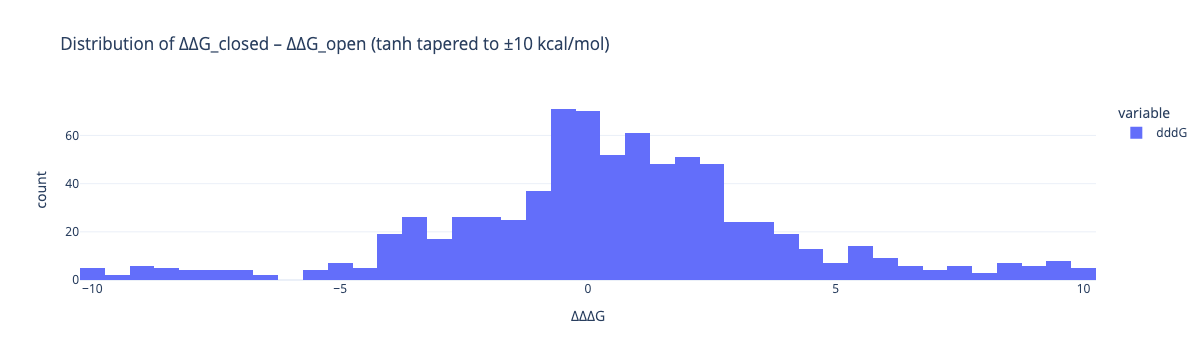

count    780.000000
mean       0.527554
std        8.265342
min     -157.524934
25%       -1.145982
50%        0.508688
75%        2.366709
max       69.077665
Name: dddG, dtype: float64

In [91]:
import plotly.express as px
import numpy as np

px.histogram(comparison.dddG.apply(lambda v: np.tanh(v/10)*10),
             template='plotly_white',
             title='Distribution of ∆∆G_closed – ∆∆G_open (tanh tapered to ±10 kcal/mol)',
             labels={'value': '∆∆∆G'}).show()
comparison.dddG.describe()

In [92]:
comparison.loc[(comparison.dddG < -1) & (comparison.closed_complex_ddG < 1.)]\
          .sort_values('dddG')\
          [['mutation_full', 'dddG', 'closed_complex_ddG','open_complex_ddG']]\
          .round(2)\
          .to_csv('point_mutations.csv')

In [100]:
# print(comparison.loc[(comparison.dddG < -1) & (comparison.closed_complex_ddG < 1.)]\
#           .sort_values('dddG')\
#           [['mutation_full', 'dddG', 'closed_complex_ddG','open_complex_ddG']]\
#           .round(1)\
#           .to_markdown(index=False)
#      )

import tarfile

with tarfile.open('mutants.tar.gz', 'w:gz') as tar:
    for mutation_full in comparison.loc[(comparison.dddG < -1) & (comparison.closed_complex_ddG < 1.)].mutation_full:
        mutation = mutation_full.split(':')[0]
        tar.add(f'variants/closed.{mutation}.pdb', arcname=f'closed_{mutation}.pdb')
        tar.add(f'variants/open.{mutation}.pdb', arcname=f'open_{mutation}.pdb')

In [94]:
# pretty picture for pymol

for i, row in comparison.loc[(comparison.dddG <= 0) & (comparison.closed_complex_ddG < 1.)]\
                          .sort_values('dddG')\
                          .drop_duplicates('residue')\
                          .iterrows():
    print(f'# {row.mutation_full} {row.dddG}')
    red = 255
    v = np.tanh(row.dddG/10)*10
    green_blue = int(255 * (1 - v / 10))
    print(f'color 0x{red:02X}{green_blue:02X}{green_blue:02X}, resi {row.mutation_full[1:-3]} and chain {row.mutation_full[-1]}')

# G22P:A -157.524933567243
color 0xFF1FD1FD, resi 22 and chain A
# P25L:A -4.674029334558213
color 0xFF16E16E, resi 25 and chain A
# S21G:A -4.567888316317294
color 0xFF16C16C, resi 21 and chain A
# S32W:A -4.405694629094683
color 0xFF168168, resi 32 and chain A
# I20Q:A -4.181398526551675
color 0xFF163163, resi 20 and chain A
# S38F:A -3.8763268429610207
color 0xFF15D15D, resi 38 and chain A
# Q17R:A -3.854001690254222
color 0xFF15C15C, resi 17 and chain A
# E5W:A -3.557327006877017
color 0xFF156156, resi 5 and chain A
# V12L:A -3.5243439179009783
color 0xFF155155, resi 12 and chain A
# S28W:A -2.8374264268973093
color 0xFF145145, resi 28 and chain A
# K40Y:A -2.477853161059784
color 0xFF13C13C, resi 40 and chain A
# T30L:A -2.4209105449928074
color 0xFF13B13B, resi 30 and chain A
# S23P:A -2.3519520955063626
color 0xFF139139, resi 23 and chain A
# D16S:A -1.6664915037052879
color 0xFF129129, resi 16 and chain A
# S36T:A -1.3658160116250428
color 0xFF121121, resi 36 and chain A
# A10S